# TensorFlow Hub 를 이용한 Transfer Learning

- Pre-trained Moblenet 사용  
- GPU 필요하므로 Colab에서 작업

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub

In [2]:
tf.__version__

'2.12.0'

In [3]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4973314546889910833
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14328594432
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14967761152523140274
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

# Strategy-1

### Tensorflow Hub 에서 PRE-TRAINED MOBILENET 의 WEIGHT 를 가져옴

- TensorFlow Hub에서 제공하는 MobileNet_v2 사전 훈련 모델을 사용하여 입력 형태가 (224, 224, 3)인 단일 계층으로 구성된 Keras 모델을 생성합니다.
- 이 모델은 주로 이미지 분류 작업에 사용되는 MobileNet_v2 아키텍처를 기반으로 합니다.

In [4]:
# url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
url = "https://tfhub.dev/google/imagenet/inception_v2/classification/5"
# url = "D:\Tutorials\TensorFlow\imagenet_inception_v2_classification_5.tar"

In [5]:
trained_mobilenet = tf.keras.models.Sequential([
    hub.KerasLayer(url, input_shape=(224,224,3))
])

In [6]:
trained_mobilenet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              11199137  
                                                                 
Total params: 11,199,137
Trainable params: 0
Non-trainable params: 11,199,137
_________________________________________________________________


- Trained_Mobilenet.input: 모델의 입력 텐서. 모델의 입력 형태는 (224, 224, 3)이며, 이는 RGB 이미지의 높이, 너비, 채널 수를 나타냄
- Trained_Mobilenet.output: 모델의 출력 텐서. 출력은 모델이 이미지를 분류하기 위해 사용하는 분류 점수를 나타냅니다.
- MobileNet_v2는 기본적으로 ImageNet 데이터 세트에 대해 훈련되어 있으므로, 출력 벡터의 길이는 1001이 됩니다.
- 각 요소는 해당 클래스의 확률 점수를 나타냅니다.

In [7]:
trained_mobilenet.input, trained_mobilenet.output

(<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'keras_layer_input')>,
 <KerasTensor: shape=(None, 1001) dtype=float32 (created by layer 'keras_layer')>)

### PRE-TRAINED MOBILENET 평가

- URL에서 이미지를 다운로드합니다.
- 이 작업은 `request.urlopen()` 함수를 사용하여 수행되며, `.read()` 함수로 이미지 데이터를 바이트로 읽습니다.
- 다운로드한 이미지를 PIL 라이브러리를 사용하여 224x224 크기로 리사이즈합니다.
- BytesIO는 파이썬의 io 모듈에 포함된 클래스로, 바이트 스트림을 메모리 상에서 파일처럼 다룰 수 있게 해줍니다.
- 이를 사용하면 디스크에 파일을 저장하지 않고도 바이트 데이터를 파일 객체처럼 읽고 쓸 수 있습니다.
- BytesIO 객체를 사용하여 이미지 데이터를 PIL 이미지 객체로 변환하고, `.resize()` 함수를 사용하여 이미지를 (224, 224) 크기로 리사이즈합니다.

In [8]:
from PIL import Image
from urllib import request
from io import BytesIO

In [9]:
url = "https://github.com/ironmanciti/MachineLearningBasic/blob/master/datasets/TransferLearningData/watch.jpg?raw=true"

In [10]:
res = request.urlopen(url).read()
sample_image = Image.open(BytesIO(res)).resize((224,224))

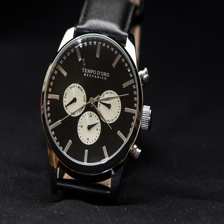

In [11]:
sample_image

- `tf.keras.applications.mobilenet.preprocess_input` 함수는 이미지 데이터를 MobileNet 모델에 맞게 전처리하는 역할을 합니다.
- 이 함수는 주어진 이미지를 NumPy 배열로 변환하고, 모델에 사용되는 특정 범위로 픽셀 값을 조정합니다 (예: -1에서 1).
- Sample_Image는 PIL.Image 객체로 크기가 (224, 224)로 조정되어 있습니다.
- 이 이미지를 np.array()를 사용하여 NumPy 배열로 변환한 다음, preprocess_input 함수를 사용하여 전처리를 수행합니다.
- x의 차원 (224, 224, 3)는 전처리된 이미지가 224x224 크기의 컬러 이미지임을 나타냅니다. 각 숫자는 각각 높이, 너비, 색상 채널 (RGB)을 나타냅니다.

In [12]:
x = tf.keras.applications.mobilenet.preprocess_input(np.array(sample_image))
x.shape

(224, 224, 3)

- `np.expand_dims(x, axis=0)`를 사용하여 이미지 배열의 모양을 (1, 224, 224, 3)으로 변경합니다.
- 이렇게 하면 입력 이미지가 하나의 배치로 처리되며, 모델은 한 번에 하나의 이미지를 예측할 수 있습니다.

In [13]:
predicted_class = trained_mobilenet.predict(np.expand_dims(x, axis=0))

1/1 [==============================] - 9s 9s/step


- `decode_predictions` 함수는 모델이 예측한 결과를 사람이 이해하기 쉬운 형태로 변환합니다.
- 이 함수는 예측된 클래스의 확률을 기반으로 상위 K개의 예측 결과를 반환합니다.
- `predicted_class[:, 1:]` 코드는 첫 번째 레이블(배경)을 제외한 나머지 확률 값을 추출합니다.
- 이렇게 하면 배경 레이블을 고려하지 않고 상위 예측 결과를 얻을 수 있습니다.

In [14]:
predicted_class, predicted_class.shape, predicted_class[:, 1:].shape

(array([[-0.09805435,  0.02527705,  0.52532065, ..., -0.5892251 ,
         -0.24023294,  0.947293  ]], dtype=float32),
 (1, 1001),
 (1, 1000))

In [15]:
tf.keras.applications.mobilenet.decode_predictions(predicted_class[:, 1:])

35363/35363 [==============================] - 0s 0us/step


[[('n04328186', 'stopwatch', 8.477461),
  ('n02708093', 'analog_clock', 7.959703),
  ('n04317175', 'stethoscope', 6.1476974),
  ('n04548280', 'wall_clock', 5.4744554),
  ('n03706229', 'magnetic_compass', 5.2076535)]]

- TensorFlow에서 제공하는 `get_file` 함수를 사용하여 'ImageNetLabels.txt' 파일을 다운로드합니다.
- 이 파일에는 ImageNet 데이터셋에 포함된 레이블들이 저장되어 있습니다.
- 다운로드된 파일은 labels_path 변수에 저장됩니다.
- `open(labels_path).read().splitlines()` 코드를 사용하여 다운로드한 텍스트 파일을 읽고 각 줄을 나눠 imagenet_labels라는 NumPy 배열에 저장합니다.

In [16]:
label_path = tf.keras.utils.get_file('ImageNetLabels.txt',
                                    'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

10484/10484 [==============================] - 0s 0us/step


In [17]:
imagenet_labels = np.array(open(label_path).read().splitlines())

In [18]:
print(imagenet_labels[:10])

['background' 'tench' 'goldfish' 'great white shark' 'tiger shark'
 'hammerhead' 'electric ray' 'stingray' 'cock' 'hen']


- `np.argmax(predicted_class)`를 사용하여 예측된 클래스 확률 중 가장 큰 값을 찾습니다.

Text(0.5, 1.0, 'Predicted Class: Stopwatch')

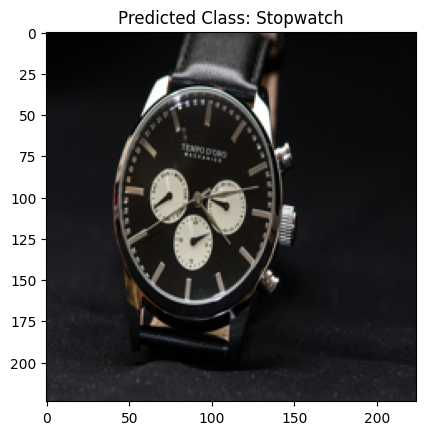

In [19]:
plt.imshow(sample_image)
predicted_class = imagenet_labels[np.argmax(predicted_class)]
plt.title(f'Predicted Class: {predicted_class.title()}')

# Stragegy-2

### Fine Tuning 전 특정 domain 의 Batch Image 에 대한 MobileNet 평가

- MobileNet 은 Flower 에 특화된 model 이 아니므로 정확도 낮을 것으로 예상됩니다.
- `get_file` 함수를 사용하여 인터넷에서 꽃 이미지 데이터셋을 다운로드합니다.
- 다운로드할 파일의 이름을 'flower_photos'로 지정하고, 데이터셋의 URL을 인자로 전달합니다.
- `untar=True`는 파일이 tar 압축 형식이므로 다운로드 후 압축을 풀어야 함을 나타냅니다.

In [20]:
flowers_data_path = tf.keras.utils.get_file('flower_photos',
                                           'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                           untar=True)

228813984/228813984 [==============================] - 6s 0us/step


- TensorFlow의 `ImageDataGenerator`를 사용하여 꽃 이미지 데이터셋에 대한 데이터 전처리를 수행합니다.
- `ImageDataGenerator`는 실시간 데이터 전처리 및 증강을 수행하며, 이미지 파일을 학습 데이터로 변환하는 데 사용됩니다.
- 이 예제에서는 MobileNet의 전처리 함수를 사용하여 이미지를 전처리합니다.
- `ImageDataGenerator` 객체인 image_generator를 생성한 후, `flow_from_directory`함수를 사용하여 로컬 파일시스템에서 이미지를 로드하고 전처리합니다.
- 이 함수는 이미지를 로드하고, 지정된 target_size(224 x 224)로 크기를 조정하며, 배치 크기를 64로 설정하여 데이터를 배치 단위로 반환합니다.
- `shuffle=True`는 데이터를 무작위로 섞어 과적합을 방지합니다.

In [21]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input
)

In [22]:
flowers_data = image_generator.flow_from_directory(flowers_data_path, target_size=(224,224), batch_size=64, shuffle=True)

Found 3670 images belonging to 5 classes.


- `next()` 함수를 사용하여 flowers_data에서 배치를 추출합니다.
- input_batch는 전처리된 이미지 데이터의 배치입니다.
- 이 경우, 배치 크기는 64이며, 각 이미지의 크기는 224 x 224 x 3이므로 배치의 모양(shape)은 (64, 224, 224, 3)입니다.
- label_batch는 이미지에 해당하는 원-핫 인코딩된 레이블 데이터의 배치입니다.
- 이 경우, 클래스 수가 5개이므로 레이블 배치의 모양은 (64, 5)입니다.
- `flowers_data.num_classes` 는 데이터셋의 클래스 수를 반환합니다. 이 경우, 꽃 데이터셋에는 5개의 클래스가 있습니다.
- `flowers_data.class_indices` 는 클래스 이름과 해당 인덱스를 포함하는 딕셔너리입니다.
- 이 정보는 이미지의 실제 레이블과 예측된 레이블을 비교할 때 유용합니다.

In [23]:
input_batch, label_batch = next(flowers_data)

In [24]:
print("Image Batch Shape: ", input_batch.shape)
print("Label Batch Shape: ", label_batch.shape)
print("Label Class 수: ", flowers_data.num_classes)
print("Class Index: ", flowers_data.class_indices)

Image Batch Shape:  (64, 224, 224, 3)
Label Batch Shape:  (64, 5)
Label Class 수:  5
Class Index:  {'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


- `flowers_data.class_indices` 딕셔너리의 키와 값의 위치를 바꾸어 새로운 딕셔너리 class_names를 생성합니다.
- 이렇게 하면, 인덱스를 사용하여 각 클래스의 이름을 쉽게 찾을 수 있습니다.

In [25]:
class_names = {v: k for k, v in flowers_data.class_indices.items()}
class_names

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

- 첫 번째 배치에서 10개의 이미지를 시각화하여 그리드에 표시 합니다.
- - 각 이미지의 전처리를 되돌려 정규화된 값을 원래 이미지의 값으로 변환합니다.

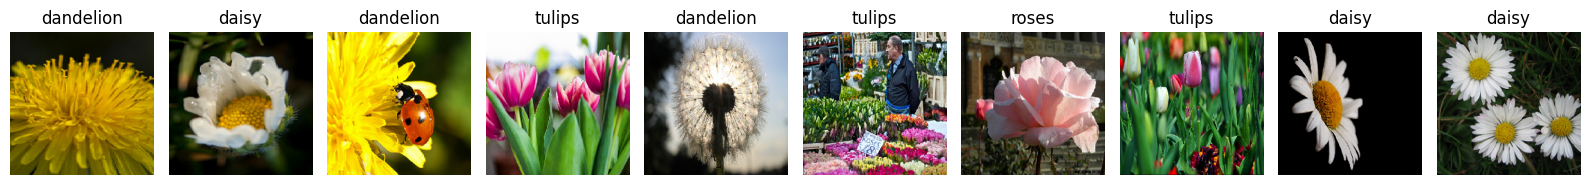

In [26]:
plt.figure(figsize=(16, 8))

for i in range(1, 11):
    plt.subplot(1, 10, i)
    img = ((input_batch[i] + 1) * 127.5).astype(np.uint8)
    idx = np.argmax(label_batch[i])
    plt.imshow(img)
    plt.title(class_names[idx])
    plt.axis('off')

plt.tight_layout()
plt.show()

- 임의의 꽃 image 1 개를 선택하여  예측을 수행합니다.

In [27]:
predictions = trained_mobilenet.predict(input_batch[2:3])

1/1 [==============================] - 0s 23ms/step


In [28]:
predictions.shape

(1, 1001)

- `decode_predictions()` 함수는 1000개의 클래스 레이블 중 확률이 가장 높은 상위 5개 결과를 인간이 이해할 수 있는 레이블로 변환해주는 함수입니다.
- 이 레이블은 [(class_id, class_name, class_probability)] 형태의 튜플 리스트로 반환합니다.

In [29]:
tf.keras.applications.mobilenet.decode_predictions(predictions[:, 1:])

[[('n11939491', 'daisy', 6.7184467),
  ('n02281787', 'lycaenid', 4.9933515),
  ('n02948072', 'candle', 4.3603163),
  ('n02206856', 'bee', 4.343609),
  ('n07613480', 'trifle', 4.33973)]]

In [ ]:
# 전이학습 MODEL 을 Flower 분류에 적합한 model 로 Retrain

### Fine Tuning 을 위해 head 가 제거된 model 을 download  

- https://tfhub.dev/s?module-type=image-feature-vector&q=tf2

In [30]:
url = "https://tfhub.dev/google/imagenet/inception_v2/feature_vector/5"
# url = "D:\Tutorials\TensorFlow\imagenet_inception_v2_feature_vector_5.tar"

In [31]:
extractor_layer = hub.KerasLayer(url, input_shape=(224, 224, 3))

In [32]:
extractor_layer.summary()

AttributeError: ignored

- extractor_layer를 통해 입력 이미지 배치를 모바일넷으로 처리한 특성 벡터 배치를 얻습니다. 반환된 feature_batch의 shape를 출력해보면면, 64개의 이미지에 대해, 각 이미지는 1280 차원의 특성 벡터로 나타납니다.

In [33]:
feature_batch = extractor_layer(input_batch)
print(feature_batch.shape)

(64, 1024)


- `extractor_layer.trainable = False`는 모델의 특정 레이어를 학습에서 제외시키는 역할을 합니다. 이를 통해 레이어의 가중치가 업데이트되지 않도록 하여 해당 레이어의 특성을 고정시켜 놓을 수 있습니다.

In [34]:
extractor_layer.trainable = False

### Model을 두 부분으로 구성

- (1) MobileNet Feature Extractor
- (2) 출력 부분에 Dense Network (classifier) 추가

In [35]:
model = tf.keras.models.Sequential([
    extractor_layer,
    tf.keras.layers.Dense(flowers_data.num_classes, activation='softmax')
])

In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1024)              10173112  
                                                                 
 dense (Dense)               (None, 5)                 5125      
                                                                 
Total params: 10,178,237
Trainable params: 5,125
Non-trainable params: 10,173,112
_________________________________________________________________


In [37]:
model.input, model.output

(<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'keras_layer_1_input')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'dense')>)

- output shape 이 정확한지 training 전에 사전 check해 봅니다.

In [38]:
predictions = model.predict(input_batch)
print(predictions.shape)

2/2 [==============================] - 2s 20ms/step
(64, 5)


In [39]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [40]:
history = model.fit(flowers_data, epochs=30)

Epoch 1/30
58/58 [==============================] - 18s 236ms/step - loss: 1.0354 - accuracy: 0.6343
Epoch 2/30
58/58 [==============================] - 13s 220ms/step - loss: 0.6034 - accuracy: 0.7970
Epoch 3/30
58/58 [==============================] - 12s 212ms/step - loss: 0.5032 - accuracy: 0.8305
Epoch 4/30
58/58 [==============================] - 13s 216ms/step - loss: 0.4418 - accuracy: 0.8548
Epoch 5/30
58/58 [==============================] - 13s 214ms/step - loss: 0.4033 - accuracy: 0.8657
Epoch 6/30
58/58 [==============================] - 13s 218ms/step - loss: 0.3736 - accuracy: 0.8738
Epoch 7/30
58/58 [==============================] - 12s 208ms/step - loss: 0.3531 - accuracy: 0.8850
Epoch 8/30
58/58 [==============================] - 13s 215ms/step - loss: 0.3315 - accuracy: 0.8932
Epoch 9/30
58/58 [==============================] - 13s 215ms/step - loss: 0.3167 - accuracy: 0.8975
Epoch 10/30
58/58 [==============================] - 13s 218ms/step - loss: 0.3014 - accura

### Flower 분류 전문으로 Fine Tuning 된 MODEL 평가

- np.argmax() 함수를 이용하여 각 샘플의 예측값 중 가장 큰 값(즉, 가장 높은 확률값)에 해당하는 인덱스를 y_pred에 저장합니다.

In [42]:
y_pred = model.predict(input_batch).argmax(axis=1)

2/2 [==============================] - 1s 68ms/step


In [43]:
y_pred

array([0, 1, 0, 1, 4, 1, 4, 2, 4, 0, 0, 1, 2, 3, 1, 2, 2, 3, 1, 4, 3, 1,
       3, 4, 1, 4, 1, 1, 3, 4, 3, 2, 2, 2, 4, 1, 3, 2, 0, 1, 4, 1, 3, 3,
       0, 3, 2, 0, 2, 0, 0, 0, 1, 0, 3, 1, 4, 2, 2, 1, 1, 0, 2, 3])

In [44]:
y_true = np.argmax(label_batch, axis=1)

In [45]:
y_true

array([0, 1, 0, 1, 4, 1, 4, 2, 4, 0, 0, 1, 2, 3, 0, 2, 2, 3, 1, 4, 3, 1,
       3, 4, 1, 4, 1, 1, 3, 4, 3, 2, 2, 2, 4, 1, 1, 2, 0, 1, 4, 1, 3, 3,
       0, 3, 1, 0, 2, 0, 0, 0, 1, 0, 3, 1, 4, 2, 2, 1, 1, 0, 2, 3])

- y_pred와 y_true 간의 일치하는 값의 비율을 계산하여 백분율로 나타냅니다

In [46]:
f"{sum(y_pred == y_true) / len(y_true) * 100:.2f} %"

'95.31 %'

- 이전과 마찬가지로  각 이미지의 전처리를 되돌려 정규화된 값을 원래 이미지의 값으로 변환합니다.

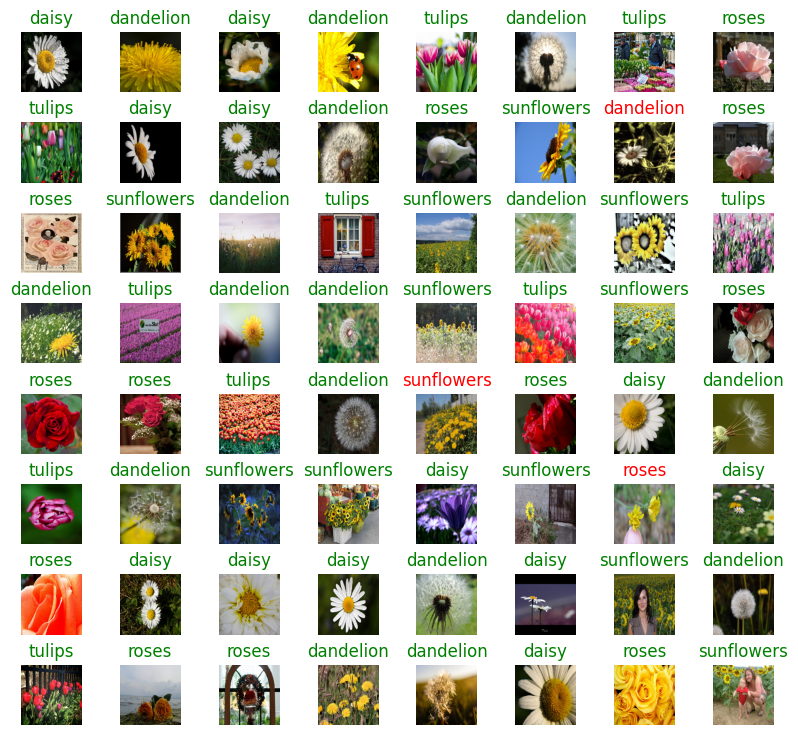

In [47]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for i in range(64):
  plt.subplot(8, 8, i+1)
  img = ((input_batch[i]+1) * 127.5).astype(np.uint8)
  plt.imshow(img)
  color = "green" if y_pred[i] == y_true[i] else "red"
  plt.title(class_names[y_pred[i]], color=color)
  plt.axis('off')